# 1. Introducción

1. **Dataset seleccionado**

  Dentro de nuestro conjunto de datos encontramos imagenes de 3 diferentes tipos de cáncer de pecho los cuales son:

  - Adenocarcinoma
  - Large cell carcinoma
  - Squamous cell carcinomay

  De la misma forma tenemos un folder con las imagenes de pecho sin ningun tipo de cáncer.

2. **¿Qué se busca resolver?**

  Nuestro modelo de aprendizaje profundo busca clasificar los diferentes tipos de cáncer de pecho que puedan ser reconocidos en cualquier persona y saber identificar uno del otro con gran precisión. Al igual de el saber diferenciar un pecho con cáncer y uno sin cáncer.

3. **Relevancia**

  La importancia de la elección de este dataset radica en el beneficio que puede generar en hospitales en alguna posible futura implementación, esto ahorraria el trabajo de cientos de personas o daría un segundo análisis a parte del dado por el doctor correspondiente para dar un diagnostico preciso.

# 2. Datos

Análisis y preprocesamiento del dataset empleado, así como separación en conjuntos de entrenamiento y prueba.

In [1]:
"""
Descargamos todas las librerias necesarias para empezar a trabajar con las imagenes.
"""

from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
from keras.src.metrics.confusion_metrics import activations
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.models import load_model
from keras.preprocessing import image

import os

from google.colab import drive

Mounted at /content/drive


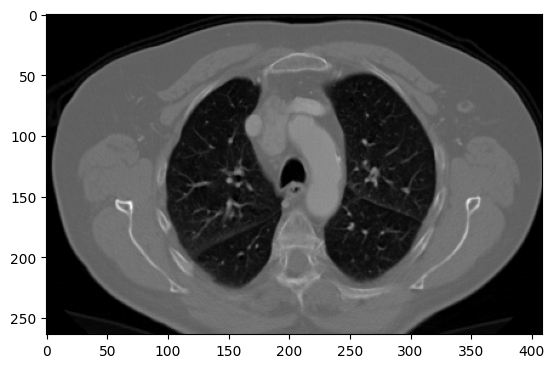

In [2]:
#Asegurarnos que podemos acceder a los datos desde drive.
drive.mount('/content/drive')

img = image.load_img('/content/drive/MyDrive/Data/train/adenocarcinoma/000000 (6).png')
plt.imshow(img)

In [3]:
"""
Se le asigna una variable a cada una de las rutas de las etapas de la creación
del modelo (entrenamiento, validación y test).
"""
train_path = '/content/drive/MyDrive/Data/train/'
valid_path = '/content/drive/MyDrive/Data/valid/'
test_path = '/content/drive/MyDrive/Data/test'


In [4]:
#Obtenemos la lista de nombres de los archivos dentro del path de test
test_classes = os.listdir(test_path)

In [5]:
"""
Dentro de estas lineas de codigo encontramos que hacemos los preprocesamientos
adecuados en cada una de las fases de las imagenes antes de alimentarlas al modelo.
"""

input_shape = (224,224,3)
classes = 4 #contamos con 4 posibles casos a partir del análisis de pecho.

"""
trainGenerator que es una instancia de la clase ImageDataGenerator perteneciente a Keras.
aplica varias transformaciones de aumento de datos en las imágenes de entrenamiento
como rotación, desplazamiento horizontal y vertical, cambio de escala,
cambio de inclinación, y volteo horizontal y vertical. De la misma forma igual las imagenes
al ser normalizadas fueron centradas en 0.
"""

trainGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

In [6]:
"""
Normalización de las imagenes.
"""
train_data = trainGenerator.flow_from_directory( #613 train
    train_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenerator.flow_from_directory( #62 validation
    valid_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenerator.flow_from_directory( #315 test o prueba
    test_path,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 3. Desarrollo del modelo

Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.

 **Arquitectura empleada**

  Para este tipo de modelo usaremos la arquitectura de CNN de redes convolutivas pero especificamente la arquitectura VGG16 que contiene 16 capas de profundidad, incluyendo capas de convolutivas, de pooling y completamente conectadas. Ya que esta es usada especificamente para el reconocimiento de imagenes y todas las tareas que involucren el procesamiento de pixeles.


In [7]:
"""
Creación del modelo VGG16:

-----------------------Parametros-----------------------------

Include_top = No incluimos las 3 capas completamente conectadas en la parte superior
de la red.

weights = Pre entrenamiento en imageNet, ayuda ya que estamos en el reconocimiento
de imagenes y es benefico ya que hace que el modelo converga en menos épocas.

input_shape = Son los canales por donde tiene inputs, es decir, alto, ancho y los 3 colores RGB, estos
ya los predefiní anteriormente.

---------------------------------------------------------------
"""
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
"""
Con esto podemos saber un poco más el estatus del modelo.
"""

model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(classes,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [9]:
"""
Al tener un modelo de tipo multiclase (ya que contamos con 4 clases)
utilicé la categorical_crossentropy con un algortimo de optimización 'adam'
que basicamente ajusta los pesos del modelo y hace que se minimice la pérdida.
"""

model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('./best_model.hdf5', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]


In [10]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 189s 5s/step - loss: 1.6768 - accuracy: 0.4062 - val_loss: 1.5715 - val_accuracy: 0.3611
Epoch 2/100
39/39 [==============================] - 15s 389ms/step - loss: 1.2383 - accuracy: 0.4682 - val_loss: 0.9881 - val_accuracy: 0.4861
Epoch 3/100
39/39 [==============================] - 14s 362ms/step - loss: 1.0550 - accuracy: 0.4845 - val_loss: 0.9380 - val_accuracy: 0.5278
Epoch 4/100
39/39 [==============================] - 14s 357ms/step - loss: 0.9570 - accuracy: 0.5514 - val_loss: 1.2207 - val_accuracy: 0.3611
Epoch 5/100
39/39 [==============================] - 14s 371ms/step - loss: 1.0104 - accuracy: 0.5318 - val_loss: 0.9336 - val_accuracy: 0.4861
Epoch 6/100
39/39 [==============================] - 14s 365ms/step - loss: 0.8541 - accuracy: 0.6101 - val_loss: 1.0399 - val_accuracy: 0.5000
Epoch 7/100
39/39 [==============================] - 14s 369ms/step - loss: 0.7984 - accuracy: 0.6395 - val_loss: 0.9757 - val_accuracy: 0

# 4. Ajuste del modelo

Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos.

# 5. Resultados

Evaluación de modelo final con datos de prueba.

In [11]:
#Validamos la precisión del modelo a partir de nuestro dataset de test.
model.save('./best_model.hdf5')
loss, acc = model.evaluate(test_data,verbose = 1)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 117s 6s/step - loss: 0.4091 - accuracy: 0.8635


In [12]:
#Vemos las predicciones del modelo
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 3s 125ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       120
           1       0.79      0.86      0.82        51
           2       0.98      0.96      0.97        54
           3       0.86      0.79      0.82        90

    accuracy                           0.86       315
   macro avg       0.87      0.87      0.87       315
weighted avg       0.87      0.86      0.86       315



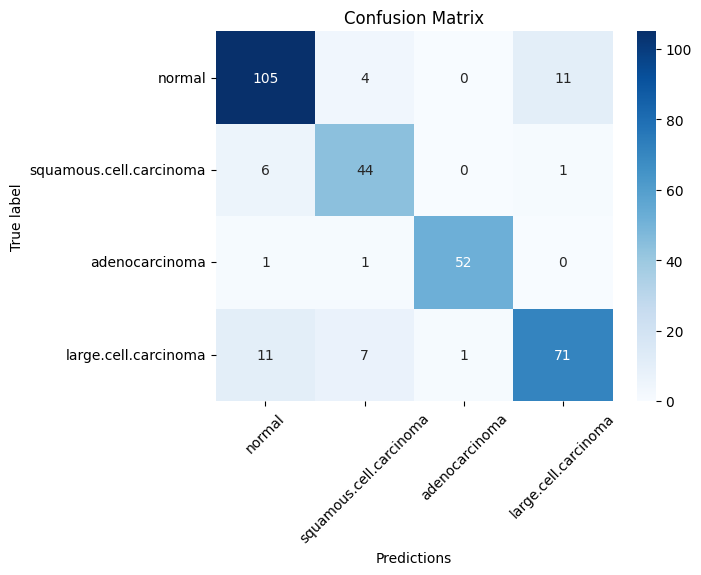

In [13]:
#Graficamos nuestra matriz de confusión
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

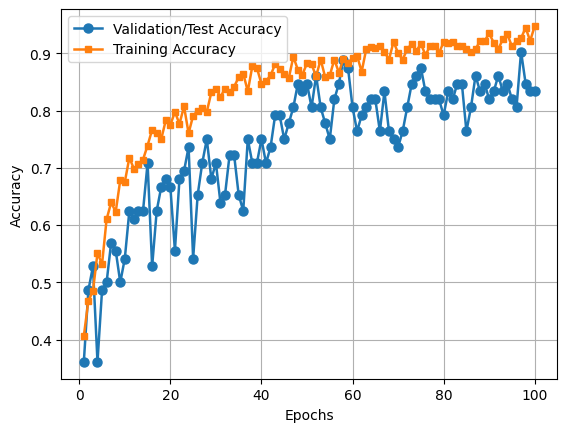

In [14]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

1/1 [==============================] - 0s 321ms/step


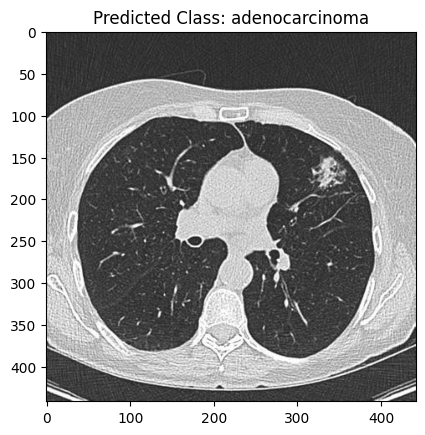

In [18]:
"""
En esta parte del codigo el modelo es capaz de solamente evaluar una sola entrada
como input y hacer la prediccion, para este ejemplo logré descargar una imagen de internet
de una tomografia de pulmones con edenocarcinoma. Como resultado de la prediccion podemos observar
que si ha logrado hacer la predicción correcta.
"""



# Guardar el modelo
model = load_model('./best_model.hdf5')

# Preprocesar una sola imagen
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

#Modificar su path para la prediccion de su imagen:
path = '/prueba1.jpg' #la ruta de la imagen sacada de internet en este ejemplo
processed_image = preprocess_image(path)

predictions_prob = model.predict(processed_image)
predicted_class = np.argmax(predictions_prob, axis=1)

class_labels = list(train_data.class_indices.keys())
predicted_label = class_labels[predicted_class[0]]

img = image.load_img(path)
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_label}')
plt.show()


# 6. Conclusiones

Análisis de los resultados obtenidos, identificación de posibles áreas de mejora:

1: Al detectar un conjunto de datos algo disparejo en las 3 fases de la creación del modelo, tuve que hacer una distribución un poco más coherente de los datos, lo cual solo me trajo un modelo con menor precisión, intenté distribuciones con valores como 0.75 en train, 0.15 en valid y 0.15 en test. Solo logrando una presición del 0.87 lo cual es considerablemente mayor a la de 0.92 conseguida en este modelo por lo cual decidí dejar este primero modelo ya que considero que es mucho mejor.

In [ ]:
#Adjunto evidencia de intento de nueva distribución de datos

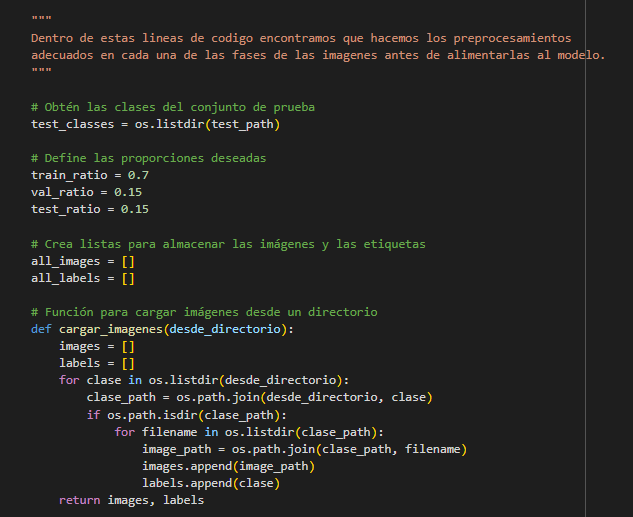

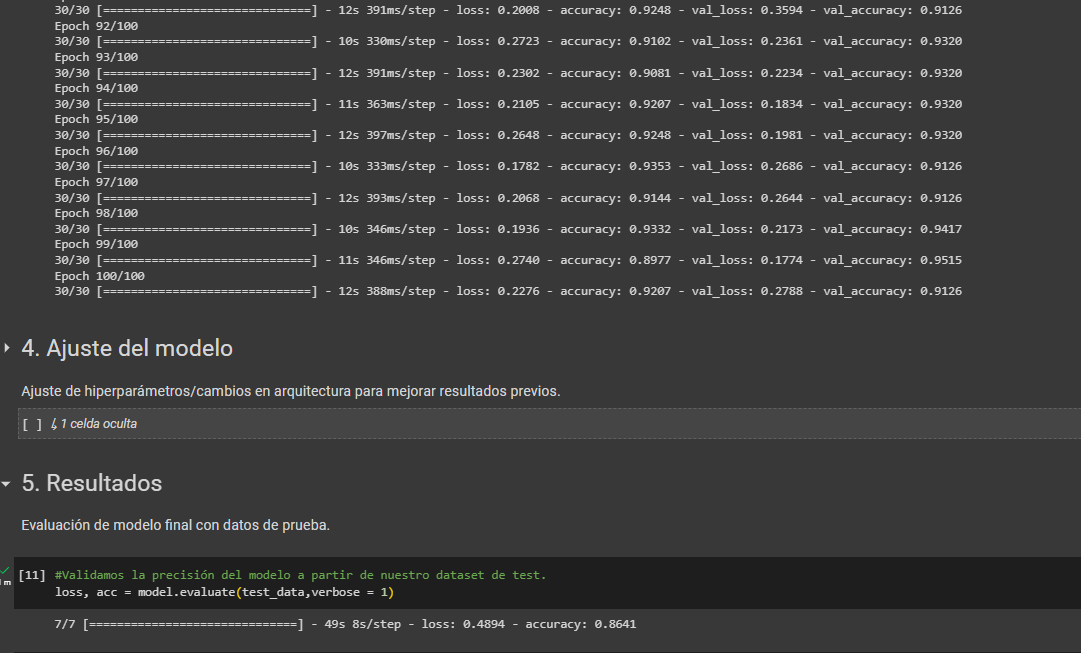